In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
if not os.path.exists("small_libs"):
    print("the directory small_libs is created")
    !git clone https://github.com/vincentvigon/small_libs
else:
    print("the directory small_libs is updated")
    %cd small_libs
    !git pull https://github.com/vincentvigon/small_libs
    %cd ..

In [ ]:
%pwd

'/content'

In [ ]:
%ls

sample_data/  small_libs/


In [ ]:
import small_libs as sl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

importation de small_libs, ajout de small_libs dans votre PYTHONPATH
small_libs importation


# Derivator

## Test 1D

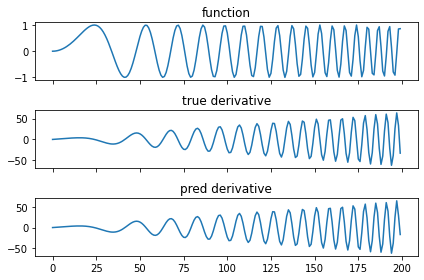

In [ ]:
def test_1d():
    L=3.4
    # si freq est un entier: pas besoin de mettre du padding
    freq=5.15
    cst=freq*2*np.pi/L
    fn=lambda x:tf.sin(cst*x**2)
    fn_x=lambda x: cst*tf.cos(cst*x**2)*2*x

    N=200
    x = np.linspace(0., L, N, endpoint=False).astype(np.float32)
    F = fn(x)
    F_x = fn_x(x)

    F = F[None, None, :, None]
    F_x = F_x[None, None, :, None]

    derivator = sl.Derivator_fft( [2], [L], lambda x: x, pad_prop=0.2)
    F_x_pred = derivator(F)

    fig,axs=plt.subplots(3,1,sharex="all")
    axs[0].set_title("function")
    axs[0].plot(F[0,0,:,0])
    axs[1].set_title("true derivative")
    axs[1].plot(F_x[0,0,:,0])
    axs[2].set_title("pred derivative")
    axs[2].plot(F_x_pred[0,0,:,0])

    fig.tight_layout()
    plt.show()

test_1d()

## Test 2d

aa (200, 300) (200, 300)


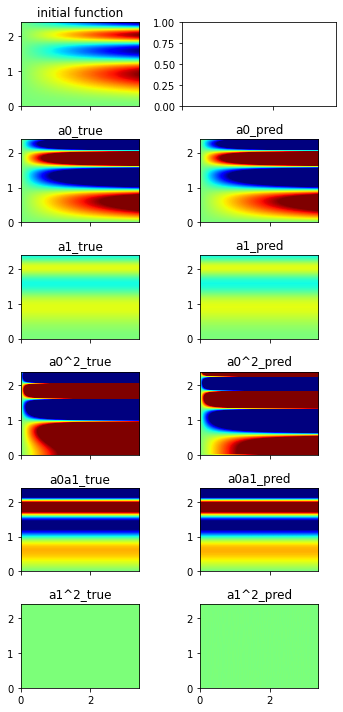

In [ ]:
def test_2d():

    # si freq est un entier: pas besoin de mettre du padding
    freq=0.3
    cst=freq*2*np.pi
    fn=lambda a0,a1:tf.sin(cst*a0**2)*a1
    fn_a0=lambda a0,a1: tf.cos(cst*a0**2)*(cst*2*a0)*a1
    fn_a1=lambda a0,a1:tf.sin(cst*a0**2)

    fn_a0a0 = lambda a0, a1: tf.cos(cst*a0**2)*(cst*2*a0)**2*a1+tf.sin(cst*a0**2)*(cst*2*a0)*a1  \
                             + tf.cos(cst*a0**2)*(cst*2)*a1
    fn_a1a1 = lambda a0, a1: tf.zeros_like(a1)
    fn_a0a1=lambda a0,a1: tf.cos(cst*a0**2)*(cst*2*a0)

    Ns=[200,300]
    Ls=[2.4,3.4]

    a0 = np.linspace(0., Ls[0], Ns[0]).astype(np.float32)
    a1 = np.linspace(0., Ls[1], Ns[1]).astype(np.float32)
    # Attention, meshgrid est prévu pour des absicisse, ordonnée. Il faut donc l'inverser
    aa0,aa1=tf.meshgrid(a0,a1)
    aa0, aa1=tf.transpose(aa0),tf.transpose(aa1)
    print("aa",aa0.shape,aa1.shape)

    F = fn(aa0,aa1)
    DF={}
    for f,name in zip([fn_a0,fn_a1,fn_a0a0,fn_a0a1,fn_a1a1],["a0","a1","a0^2","a0a1","a1^2"]):
        DF[name]=f(aa0,aa1)

    derivator = sl.Derivator_fft([0, 1], Ls,
        formula=lambda a0, a1: {"a0": a0, "a1": a1, "a0^2": a0 ** 2, "a1^2": a1 ** 2,"a0a1":a0*a1})
    DF_fft=derivator(F)

    extent = [0., Ls[1], 0., Ls[0]]
    fig, axs = plt.subplots(6,2, figsize=(5, 10),sharex="all")
    axs[0, 0].imshow(F, extent=extent, cmap="jet", origin="lower")
    axs[0, 0].set_title("initial function")

    vmin,vmax=-4,4
    for i,key in enumerate(["a0","a1","a0^2","a0a1","a1^2"]):
        axs[i+1,0].imshow(DF[key],extent=extent,cmap="jet",origin="lower",vmin=vmin,vmax=vmax)
        axs[i + 1, 0].set_title(key+"_true")
        axs[i+1,1].imshow(DF_fft[key],extent=extent,cmap="jet",origin="lower",vmin=vmin,vmax=vmax)
        axs[i + 1, 1].set_title(key+"_pred")

    plt.tight_layout()
    plt.show()

test_2d()

## Simple dérivation suivant 2 axes

In [ ]:
x = tf.linspace(0.,1,100)
a0 = x[:,None]
a1 = x[None,:]

In [ ]:
derivator = sl.Derivator_fft(axes=[0,1],interval_lenghts=[1,1],formula=lambda a0,a1:[a0,a1])

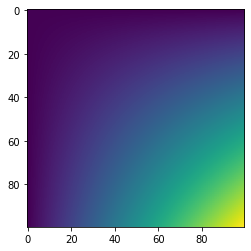

In [ ]:
F = a0*a1
plt.imshow(F);

In [ ]:
F_a0,F_a1 = derivator(F)

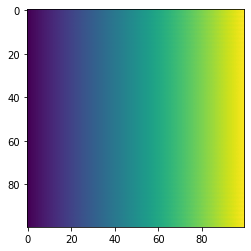

In [ ]:
plt.imshow(F_a0);

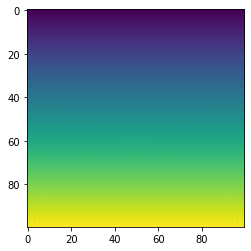

In [ ]:
plt.imshow(F_a1);

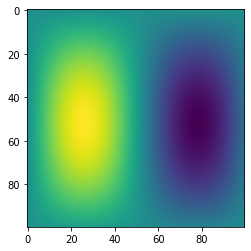

In [ ]:
F=tf.sin(3*a0)*tf.sin(6*a1)
plt.imshow(F);

In [ ]:
F_a0,F_a1=derivator(F)

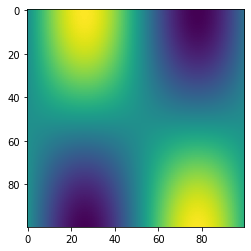

In [ ]:
plt.imshow(F_a0);

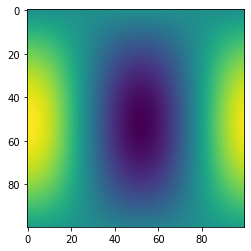

In [ ]:
plt.imshow(F_a1);

## Calcul d'une divergence en dim 4

In [ ]:
def test_divergence(N,graph_acceleration):
    
    a0=tf.linspace(0,1,N)
    a1=tf.linspace(0,1,N)
    a2=tf.linspace(0,1,N)
    a3=tf.linspace(0,1,N)

    a0_=a0[:,None,None,None]
    a1_=a1[None,:,None,None]
    a2_=a2[None,None,:,None]
    a3_=a3[None,None,None,:]

    func=lambda a0,a1,a2,a3:a0**2+a1**2+a2**2+a3**2
    div_func=lambda a0,a1,a2,a3: 2*a0+2*a1+2*a2+2*a3

    F=func(a0_,a1_,a2_,a3_)
    div_F=div_func(a0_,a1_,a2_,a3_)

    ti0=time.time()
    derivator_fft=sl.Derivator_fft([0,1,2,3],[1,1,1,1],lambda a0,a1,a2,a3:a0+a1+a2+a3,graph_acceleration=graph_acceleration)
    print("création de l'objet, durée:",time.time()-ti0)

    ti0=time.time()
    div_F_pred=derivator_fft(F)
    print("premier appel de la dérivation:",time.time()-ti0)
    ti0=time.time()
    div_F_pred=derivator_fft(F)
    print("second appel de la dérivation:",time.time()-ti0)

    error=tf.reduce_mean(tf.abs(div_F-div_F_pred))
    print("error",error)

In [ ]:
%%time
test_divergence(80,True)

création de l'objet, durée: 1.71661376953125e-05
traçage de la méthode de dérivation du Derivator_fft, temps de traçage: 2.070065498352051
premier appel de la dérivation: 3.3445143699645996
traçage de la méthode de dérivation du Derivator_fft, temps de traçage: 0.9450573921203613
second appel de la dérivation: 1.0792179107666016
error tf.Tensor(0.08505633984118822, shape=(), dtype=float64)
CPU times: user 4.14 s, sys: 207 ms, total: 4.34 s
Wall time: 5.81 s


In [ ]:
%%time
test_divergence(80,False)

création de l'objet, durée: 9.298324584960938e-06
premier appel de la dérivation: 0.36830830574035645
second appel de la dérivation: 0.24556303024291992
error tf.Tensor(0.08505633984118734, shape=(), dtype=float64)
CPU times: user 492 ms, sys: 98 ms, total: 590 ms
Wall time: 817 ms


In [ ]:
np.log(80**4*36)/np.log(10)

9.168662448735061

Le tenseur fait 1 giga

## Influence du padding

In [ ]:
def test_precision():

    L=3.4
    # si freq est un entier: pas besoin de mettre du padding
    freq=5.15
    cst=freq*2*np.pi/L
    fn=lambda x:tf.sin(cst*x**2)
    fn_x=lambda x: cst*tf.cos(cst*x**2)*2*x

    fig,axs=plt.subplots(4,1,figsize=(10,10))

    Ns = [15, 30, 50, 75, 100, 200, 300, 400, 800,1500]

    errors_df_1=[]
    errors_df_2=[]


    for N in Ns:
        x = np.linspace(0., L, N, endpoint=False).astype(np.float32)
        F = fn(x)
        F_x = fn_x(x)
        F_x_df = sl.Dx(F, L / N)
        error_df_1 = tf.reduce_mean(tf.abs(F_x_df - F_x))
        error_df_2 = tf.reduce_mean(tf.square(F_x_df - F_x))

        errors_df_1.append(error_df_1)
        errors_df_2.append(error_df_2)


    def one_pad_prop(pad_prop):
        print("pad_prop",pad_prop)

        def one_N(N:int):
            print(f"test with N={N}")

            x=np.linspace(0.,L,N,endpoint=False).astype(np.float32)
            F=fn(x)
            F_x=fn_x(x)

            F=F[None,None,:,None]
            F_x=F_x[None,None,:,None]

            derivator=sl.Derivator_fft([2],[L],lambda x:x,pad_prop)
            F_x_pred=derivator(F)
            error_1=tf.reduce_mean(tf.abs(F_x_pred-F_x))
            error_2=tf.reduce_mean(tf.square(F_x_pred-F_x))

            return error_1,error_2

        errors_1=[]
        errors_2=[]

        for N in Ns:
            error_1,error_2=one_N(N)
            errors_1.append(error_1)
            errors_2.append(error_2)

        axs[0].plot(Ns,errors_1,"o-",label=f"mae, pad_prop={pad_prop}")
        axs[1].plot(Ns,errors_2,"o-",label=f"mse, pad_prop={pad_prop}")


    for pad_prop in [0,0.1,0.2,0.5,1]:
        one_pad_prop(pad_prop)

    axs[0].plot(Ns,errors_df_1,"o-",label="mae, finite diff")
    axs[1].plot(Ns,errors_df_2,"o-",label="mse, finite diff")

    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    axs[0].legend()
    axs[1].legend()

    t=tf.linspace(0.,L,1000)
    F=fn(t)
    Fx=fn_x(t)
    axs[2].plot(t,F,label='fonc')
    axs[3].plot(t,Fx,label='der')
    axs[2].legend()
    axs[3].legend()

    plt.tight_layout()
    plt.show()